# StockBrain 0.0.1
(c) R. Varadharajan, [Vist webpage www.ramanathanvaradharajan.com](https://www.ramanathanvaradharajan.com)

StockBrain 0.0.1 (also called as *Telencephalon*) is our beta version of DeepLearning algorithm to predict the stock price. We demonstrate the ability of our model over NYSE:RDS.A (Royal Dutch Shell A sold at Newyork stock exchange). StockBrain uses deep learning recurrent neural networks from Keras module. Keras requires a backend package like Tensorflow, Theano or CNTK. We recommend to use Theano backend. Keras uses tensorflow by default. To change the keras backend visit [Keras website](https://www.keras.org)

Tested on.  
OS: Windows 10  
Processor: Intel Pentium 4415Y, 1.6 MHz, 2 cores, 4 processors  
Python: 3.8.2 64-bit  
Keras: 2.3.4  
Theano: 1.0.4 for Keras backend.  


# Importing necessary libraries

For plot styles check the reference style of graphs [here](https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html)

In [5]:
import math
import numpy as np
import pandas as pd 
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt 
plt.style.use('dark_background') 


# Download live data

Get the stock quote from the [Yahoo finance](https://finance.yahoo.com/lookup).  
There should be better upto date quotes available. For now we only have Yahoo that allows for an easy API. Further, implementation in future needs to have a drop down list of stocks to be chosen by the user. User input should determine which stock should be downloaded. For the application purposes, the models need hours of compute time. Thus, the downloaded quote will be used to update the model in the background. In the foreground, existing model will be used to predict the future price. 


In [12]:
df_source = web.DataReader('RDS-A', data_source='yahoo', start='2000-01-03', end='2020-04-21')
ar_columns = np.array(df_source.columns)

# Show data

Let's visualize the closing price of the stock. Stock data normaly has five columns. This column index is saved as an array of strings in ar_columns. Later versions should present the user with the downloaded stock price. Let's plot the ```df_source[['close']] ```.

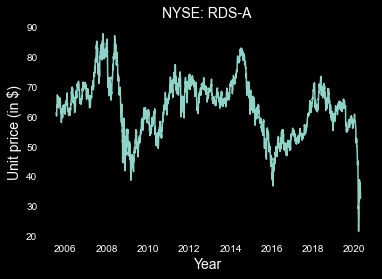

In [7]:
plt.figure()
plt.title('NYSE: RDS-A ', fontsize = 14)
plt.plot(df_source[['Close']])
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Unit price (in $)', fontsize = 14)
plt.show()

# Preprocessing

We do not want the whole dataframe. We only need the stock close price. We will run our recurrent neural network over the close price and predict the future close price. Later, we can add options to predict the open price. To do this we might need to consider the opening price. For now, let's keep it simple. We will use the ```pandas.DataFrame.filter```. Using this ```filter``` we can keep the ```index``` of our original ```df_source``` as such. This will thus become our new data frame. Since this is going to be the data on which we are going to operate. Let's name this as ```df_data```.  

After filtering our data to just ```Close``` column, we have to convert our dataframe into numpy array. This can be done using the ```pandas.DataFrame.values```. Result is an ```numpy.ndarray``` of all the ```Close``` price of the stock. Note, we do not consider the effect of date as our stocks prices are **assumed to be evenly spaced**. This apparently is wrong, as weekends, festivals, official holidays are all ignored. Stock prices jump during these intervals (in my opinion). Such sharp peaks, though very regular are not always in the same direction. _This is where our neural network is far better than exisiting ones._ Our propreitary algorithm takes into (_and will_) this and several other effects (_in future_).

In [17]:
df_data = df_source.filter(['Close'])
ar_data = df_data.values

## Define training data length

This is an important parameter. We can use the whole downloaded data to train our model. That ofcourse will be a bad practise. In principle, we have to use the K-4 method. That is for later time. _Telencephalon_ is too young to do that! _Telencephalon_ will only consider one split of data into a train and test. We can define this as a percentage. This is not an user input. This is built-in. _StockBrain_ choses this parameter based on a separate analysis (_in future_). For demonstration, let's fix a fixed length to our train data. The length should be rounded off to an integer value. It is thus an interger property. This length determines the number of samples we will use to train our Neural network. So it as integer number of samples. By following our naming convention we will define this variable as ```it_nsamples```. This should be a rounded integer of 90% of ```ar_data```.

In [20]:
it_nsamples = math.ceil(len(ar_data)*0.9)
print('Number of samples to be used for training : ', it_nsamples)

Number of samples to be used for training :  3342


In [95]:
# create new datasets with only the close prices
data_rds = df_rds.filter(['Close'])
data_numpy_rds = data_rds.values
data_rds_training_length = math.ceil(len(data_numpy_rds)*0.9) 

# perform same operation for brent crude
data_brent = df_brent.filter(['Close'])
data_numpy_brent = data_brent.values
data_brent_training_length = math.ceil(len(data_numpy_brent)*0.9)


In [96]:
# scale the data using sklearn MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_rds_scaled = scaler.fit_transform(data_numpy_rds)
data_brent_scaled = scaler.fit_transform(data_numpy_brent)


In [97]:
data_rds_scaled.shape

(3713, 1)

In [98]:
# Lets use this scaled data to define our training data set
training_data_rds = data_rds_scaled[0:data_rds_training_length, :]
# We are going to set our x_train and y_train from the training_data_rds
x_train = []
y_train = []
for i in range(100, len(training_data_rds)):
    x_train.append(training_data_rds[i-100:i,0])
    y_train.append(training_data_rds[i,0])

In [99]:
# Let's convert the training data into numpy array and reshape it to pass it to LSTM
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(3242, 100, 1)

## Finally let's build our LSTM model.

In [100]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [101]:
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [102]:
# Train the neural network
model.fit(x_train,y_train,batch_size=1,epochs=1)

Epoch 1/1
3242/3242 [==============================] - 42950s 13s/step - loss: 0.0017


In [103]:
# create a test data set.
test_data = data_rds_scaled[data_rds_training_length-100: , :]
x_test = []
#y test contains unscaled real data to be tested
y_test = data_numpy_rds[data_rds_training_length:,:]
#x test has past 10 values for every y test data.
for i in range(100, len(test_data)):
    x_test.append(test_data[i-100:i,0])

In [104]:
# convert the x test into an numpy array so that we can use it in LSTM
x_test = np.array(x_test)

In [105]:
# reshape it to pass it into LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Get the prediction from Neural network

In [106]:
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)

In [107]:
## Accuracy of the model using RMSE.  (0 is perfect prediction.)
rmse = np.sqrt( np. mean( (prediction - y_test)**2))
rmse


10.138034111075891

## Visualize the model validation step

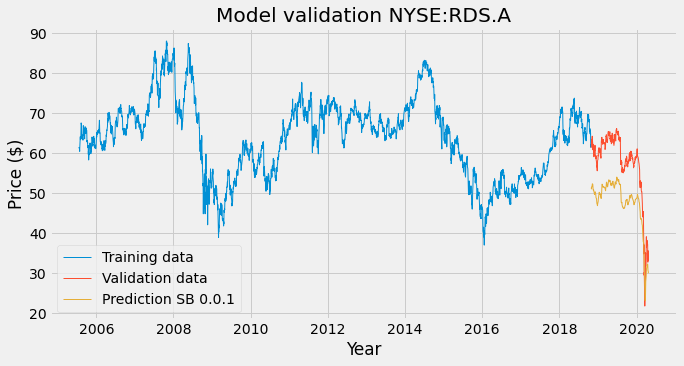

In [113]:
train = data_rds[:data_rds_training_length]
valid = data_rds[data_rds_training_length:]
valid['Prediction']=prediction
plt.figure(figsize=(10,5))
plt.title('Model validation NYSE:RDS.A')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.plot(train['Close'], linewidth=1)
plt.plot(valid[['Close','Prediction']], linewidth=1)
plt.legend(['Training data','Validation data', 'Prediction SB 0.0.1'])
plt.show()

We stop at this. There is more to do. But we are taking our steps slowly and steadily in the right direction.  
##### StockBrain 0.0.1 
will come soon!